In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
import scipy as sp

from scipy.signal import argrelmin, argrelmax

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Lambda, Dense, Input, Layer
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

Using TensorFlow backend.


In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
from matplotlib.font_manager import FontProperties

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

fontP = FontProperties()
fontP.set_size(10)

In [4]:
# Check Versions
print(tf.__version__)  #1.15.0
print(keras.__version__)  #2.2.4

1.15.0
2.2.4


# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_i)-\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i)))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})-\sum_{i\in\bf{\theta}}\frac{f(x_{T,i},\theta')}{(1-f(x_{T,i},\theta'))}\log (1-g(x_{D,i})))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the original Gaussian DCTR Example.

We will now parametrize our network by giving it a $\mu$ value in addition to $X_{i,0}\sim\mathcal{N}(\mu, 1)$ and $X_{i,1}\sim\mathcal{N}(0, \nu)$, where $\nu = (\omega_0 +\omega_1\mu)^2$ for some constant terms $\omega_0$, $\omega_1$ and $X_{i,1}$ is a secondary truth observable that will determinte detector effects for $X_{i,0}$.

First we uniformly sample $\mu$ values in some range

We then sample from normal distributions with this $\mu$ and its respective $\nu$ value.

Please note that the samples in X0 are not paired with $\mu=0$ as this would make the task trivial. 

Instead it is paired with the $\mu$ values uniformly sampled in the specified range [mu_min, mu_max].

For every value of $\mu$ in mu_values, the network sees one event drawn from $(\mathcal{N}(0,1),\mathcal{N}(0,\nu_{0}))$ and $(\mathcal{N}(\mu,1),\mathcal{N}(0,\nu_{\mu}))$, and it learns to classify them. 

i.e. we have one network that's parametrized by $\mu$ that classifies between events from $(\mathcal{N}(0,1),\mathcal{N}(0,\nu_{0}))$ and $(\mathcal{N}(\mu,1),\mathcal{N}(0,\nu_{\mu}))$, and a trained network will give us the likelihood ratio to reweight from one to another. 

## Build and Train DCTR model

In [5]:
def nu(theta):
    omega_0 = 0.7  # Smearing width
    omega_1 = 0.2
    return (omega_0 + omega_1 * theta)**2

In [6]:
# Either load or train DCTR
def get_dctr(load=False, n_data_points=10**6, mu_min=-2, mu_max=2):
    if load:
        json_file = open('1d_gaussian_dctr_model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        dctr_model = keras.models.model_from_json(loaded_model_json)
        # load weights into new model
        dctr_model.load_weights("1d_gaussian_dctr_model.h5")
        print("Loaded model from disk")
    else:

        # Generate training & validation data
        mu_values = np.random.uniform(mu_min, mu_max, n_data_points)

        X0 = [(np.random.normal(0, 1), np.random.normal(0, nu(0)), mu)
              for mu in mu_values]  # Note the zero in normal(0, 1)

        X1 = [(np.random.normal(mu, 1), np.random.normal(0, nu(mu)), mu)
              for mu in mu_values]

        Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
        Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

        X = np.concatenate((X0, X1))
        Y = np.concatenate((Y0, Y1))

        X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                            Y,
                                                            test_size=0.5)

        # Build Model
        inputs = Input((3, ))
        hidden_layer_1 = Dense(50, activation='relu')(inputs)
        hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
        hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
        outputs = Dense(2, activation='softmax')(hidden_layer_3)

        dctr_model = Model(inputs=inputs, outputs=outputs)
        dctr_model.compile(loss='categorical_crossentropy',
                           optimizer='Adam',
                           metrics=['accuracy'])

        # Train Model
        earlystopping = EarlyStopping(patience=10, restore_best_weights=True)
        dctr_model.fit(X_train,
                       Y_train,
                       epochs=200,
                       batch_size=10000,
                       validation_data=(X_test, Y_test),
                       callbacks=[earlystopping],
                       verbose=0)
        print("Trained DCTR Model")

    return dctr_model

### Loading Model

In [7]:
mu_min = -2
mu_max = 2

dctr_model = get_dctr(n_data_points = 10**7, mu_min=mu_min, mu_max=mu_max)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Trained DCTR Model


### Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [8]:
# from NN (DCTR)
def reweight(events, param):
    # creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape=(events.shape[0], 1)) * param
    # combining and reshaping into correct format:
    model_inputs = K.concatenate((events, concat_input_and_params), axis=-1)
    f = dctr_model(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights

## Validate DCTR for any $\mu$

### Validate for Truth Level

In [9]:
mu1 = 1.5
assert mu1 >= mu_min and mu1 <= mu_max  # choose mu1 in valid range
X0_val_T_0 = np.random.normal(0, 1, 10**6)
X0_val_T_1 = np.random.normal(0, nu(0), 10**6)
X0_val_T = np.stack((X0_val_T_0, X0_val_T_1), axis=-1)

X1_val_T_0 = np.random.normal(mu1, 1, 10**6)
X1_val_T_1 = np.random.normal(0, nu(mu1), 10**6)
X1_val_T = np.stack((X1_val_T_0, X1_val_T_1), axis=-1)

In [10]:
weights_val = reweight(tf.convert_to_tensor(X0_val_T, dtype=tf.float32), mu1)
weights_val = K.eval(weights_val)

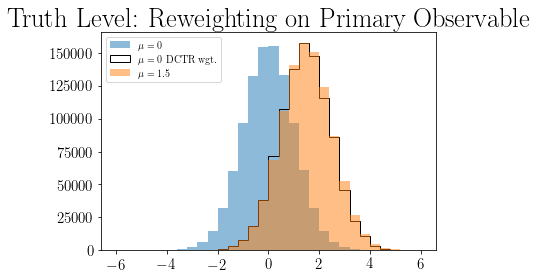

In [11]:
bins = np.linspace(-6, 6, 31)
plt.hist(X0_val_T[:,0], bins=bins, alpha=0.5, label=r'$\mu=0$')
plt.hist(X0_val_T[:,0],
         bins=bins,
         label=r'$\mu=0$ DCTR wgt.',
         weights=weights_val,
         histtype='step',
         color='k')
plt.hist(X1_val_T[:,0], bins=bins, alpha=0.5, label=r'$\mu={}$'.format(mu1))
plt.legend(prop=fontP)
plt.title("Truth Level: Reweighting on Primary Observable")
#plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Truth-Level:Reweighting-on-Primary-Observable.png")
plt.show()

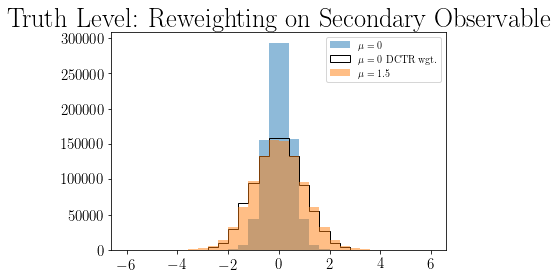

In [12]:
bins = np.linspace(-6, 6, 31)
plt.hist(X0_val_T[:,1], bins=bins, alpha=0.5, label=r'$\mu=0$')
plt.hist(X0_val_T[:,1],
         bins=bins,
         label=r'$\mu=0$ DCTR wgt.',
         weights=weights_val,
         histtype='step',
         color='k')
plt.hist(X1_val_T[:,1], bins=bins, alpha=0.5, label=r'$\mu={}$'.format(mu1))
plt.legend(prop=fontP)
plt.title("Truth Level: Reweighting on Secondary Observable")
#plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Truth-Level:Reweighting-on-Secondary-Observable.png")
plt.show()

### Validate for Detector Level

To apply detector effects, each event's primary truth observable $x_{T,i,0}$in the sample is smeared by shifting by $Z_{i}$ from $Z = \mathcal{N}(0,(x_{T,i,1})^2)$ ,where the square of the secondary truth observable $x_{T,i,1}$ represents the smearing. Thus: $x_{D,i} = x_{T,i,0} + Z_{i}$

In [13]:
# Generate detector level by smearing truth

X0_val_D = np.array([(x[0] + np.random.normal(0, x[1]**2))
                     for x in X0_val_T])  # Detector smearing
X1_val_D = np.array([(x[0] + np.random.normal(0, x[1]**2))
                     for x in X1_val_T])  # Detector smearing

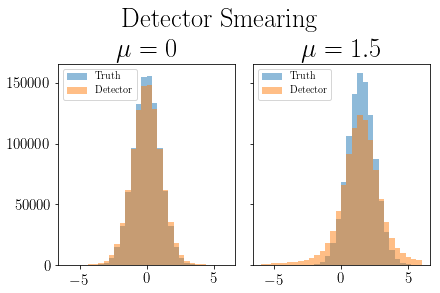

In [14]:
fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('Detector Smearing')
axs[0].set_title('$\mu=0$')
axs[0].hist(X0_val_T[:,0], bins=bins, alpha=0.5, label='Truth')
axs[0].hist(X0_val_D, bins=bins, alpha=0.5, label='Detector')
axs[0].legend(prop=fontP, loc = 'upper left')
axs[1].set_title('$\mu={}$'.format(mu1))
axs[1].hist(X1_val_T[:,0], bins=bins, alpha=0.5, label='Truth')
axs[1].hist(X1_val_D, bins=bins, alpha=0.5, label='Detector')
axs[1].legend(prop=fontP, loc = 'upper left')
fig.show()

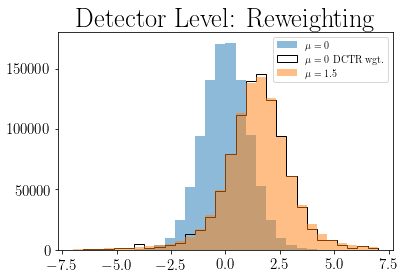

In [15]:
bins = np.linspace(-7, 7, 31)
plt.hist(X0_val_D, bins=bins, alpha=0.5, label=r'$\mu=0$')
plt.hist(X0_val_D,
         bins=bins,
         label=r'$\mu=0$ DCTR wgt.',
         weights=weights_val,
         histtype='step',
         color='k')
plt.hist(X1_val_D, bins=bins, alpha=0.5, label=r'$\mu={}$'.format(mu1))
plt.legend(prop=fontP)
plt.title("Detector Level: Reweighting")
#plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Detector-Level:Reweighting.png")
plt.show()

# Alternative Fit

## Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

To apply detector effects, each event's primary truth observable $x_{T,i,0}$in the sample is smeared by shifting by $Z_{i}$ from $Z = \mathcal{N}(0,(x_{T,i,1})^2)$ ,where the square of the secondary truth observable $x_{T,i,1}$ represents the smearing. Thus: $x_{D,i} = x_{T,i,0} + Z_{i}$

In [16]:
N = 10**6
theta0_param = 0  # this is the simulation ... N.B. this notation is reversed from above!
theta1_param = 1  # this is the data (the target)
sigma = 1.  # standard Gaussian width
# epsilon = sigma / 2  # Smearing width

theta0_T_0 = np.random.normal(theta0_param, sigma, N)  # Truth Level Data
theta0_T_1 = np.random.normal(0, nu(theta0_param), N)
theta0_T = np.stack((theta0_T_0, theta0_T_1), axis = -1)

theta0_D = np.array([(x[0] + np.random.normal(0, x[1]**2))
                     for x in theta0_T])  # Detector smearing

theta0 = np.hstack([theta0_T, np.expand_dims(theta0_D, axis = -1)])

theta1_T = np.random.normal(theta1_param, sigma, N)
theta1_T_ep = np.random.normal(0, nu(theta1_param), N)
theta1_T = np.stack((theta1_T, theta1_T_ep), axis = -1)

theta1_D = np.array([(x[0] + np.random.normal(0, x[1]**2))
                     for x in theta1_T])  # Detector smearing

theta1 = np.hstack([theta1_T, np.expand_dims(theta1_D, axis = -1)])

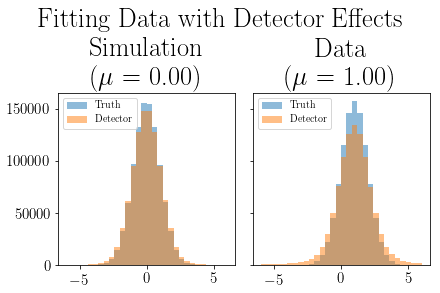

In [17]:
bins = np.linspace(-6, 6, 31)

fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('Fitting Data with Detector Effects')

axs[0].set_title("Simulation\n($\mu$ = {:.2f})".format(theta0_param))
axs[0].hist(theta0_T[:,0], bins=bins, alpha=0.5, label='Truth')
axs[0].hist(theta0_D, bins=bins, alpha=0.5, label='Detector')
axs[0].legend(prop=fontP, loc = 'upper left')

axs[1].set_title("Data\n($\mu$ = {:.2f})".format(theta1_param))
axs[1].hist(theta1_T[:,0], bins=bins, alpha=0.5, label='Truth')
axs[1].hist(theta1_D, bins=bins, alpha=0.5, label='Detector')
axs[1].legend(prop=fontP, loc = 'upper left')

# fig.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Fitting-Data-with-Detector-Effects.png")
plt.show()

Notice how detector smearing is more intense for "Data".

In [18]:
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0, theta1])
yvals = np.concatenate([labels0, labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                    yvals,
                                                    test_size=0.5)
X_train_theta, y_train_theta = shuffle(xvals, yvals)

X_train_T, y_train_T = np.copy(X_train[:, :2]), y_train
X_test_T, y_test_T = np.copy(X_test[:, :2]), y_test
X_train_theta_T, y_train_theta_T = np.copy(X_train_theta[:, :2]), y_train_theta

#' Erasing' Truth level for data, we can't actually observe this
X_train[:, :2][y_train == 1], X_test[:, :2][y_test == 1] = 0., 0.
X_train_theta[:, :2][y_train_theta == 1] = 0.

# 'hiding' truth level for simulation in expected model output (used in reweighting)
X_train_D, y_train_D = X_train[:, 2], np.hstack([np.expand_dims(y_train, axis = -1), X_train[:, :2]])
X_test_D, y_test_D = X_test[:, 2], np.hstack([np.expand_dims(y_test, axis=-1), X_test[:, :2]])

X_train_theta_D, y_train_theta_D = X_train_theta[:, 1], np.hstack(
    [np.expand_dims(y_train_theta, axis = -1), X_train_theta[:, :2]])

## Fitting Model: Scan

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

### Creating Model

In [19]:
myinputs = Input(shape=(2, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model_T = Model(inputs=myinputs, outputs=predictions)
model_T.summary()
batch_size = 1000

earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

thetas = np.linspace(-2, 2, 17)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 17,025
Trainable params: 17,025
Non-trainable params: 0
_________________________________________________________________


### Truth Level Scan

In [20]:
def my_loss_wrapper_T(inputs,
                      val=0.,
                      reweight_type='DCTR',
                      loss='MSE',
                      batch_size=1000):
    x = inputs
    x = K.gather(x, np.arange(batch_size))

    theta_prime = val

    if reweight_type == 'DCTR':
        # NN (DCTR) reweight
        weights = reweight(x, theta_prime)
    elif reweight_type == 'analytical':
        # analytical reweight
        weights = analytical_reweight(x, theta_prime)
    else:
        raise ValueError("reweight_type must be set to 'DCTR' or 'analytical'")

    def my_loss(y_true, y_pred):
        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + weights * (
                1. - y_true) * (y_true - y_pred)**2
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")

        return K.mean(t_loss)

    return my_loss

In [21]:
lvals_T = []
vlvals_T = []

for theta in thetas:
    print("Testing theta = ", theta)
    model_T.compile(optimizer='adam',
                  loss=my_loss_wrapper_T(myinputs,
                                         theta,
                                         loss='categorical_crossentropy',
                                         batch_size=batch_size),
                  metrics=['accuracy'])

    history = model_T.fit(np.array(X_train_T),
                        y_train_T,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(np.array(X_test_T), y_test_T),
                        verbose=0,
                        callbacks=[earlystopping])

    min_lval = history.history['loss'][np.argmin(history.history['val_loss'])]
    min_vlval = np.min(history.history['val_loss'])

    lvals_T += [min_lval]
    vlvals_T += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass
print(lvals_T)

Testing theta =  -2.0
loss:  0.072893809851259
val_loss:  0.07296998900920153


Testing theta =  -1.75
loss:  0.10645187297463417
val_loss:  0.10676406958699226


Testing theta =  -1.5
loss:  0.14691563938558103
val_loss:  0.14716144003719092


Testing theta =  -1.25
loss:  0.1967926810979843
val_loss:  0.19705515007674695


Testing theta =  -1.0
loss:  0.2559635700285435
val_loss:  0.25611121925711633


Testing theta =  -0.75
loss:  0.3221166207194328
val_loss:  0.3221927546262741


Testing theta =  -0.5
loss:  0.3939623568058014
val_loss:  0.3940866264998913


Testing theta =  -0.25
loss:  0.4687837936282158
val_loss:  0.46901719698309896


Testing theta =  0.0
loss:  0.5400358861386776
val_loss:  0.5407896610498428


Testing theta =  0.25
loss:  0.60183519500494
val_loss:  0.6032469509243965


Testing theta =  0.5
loss:  0.6497758188843727
val_loss:  0.651574793279171


Testing theta =  0.75
loss:  0.6796265326738358
val_loss:  0.6812339643239975


Testing theta =  1.0
loss:  0.6888

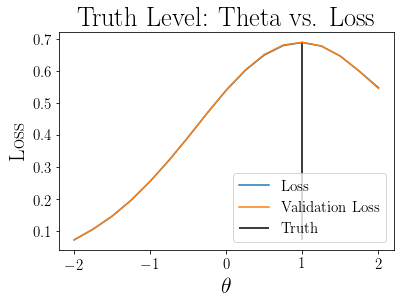

In [22]:
plt.title("Truth Level: Theta vs. Loss")
plt.plot(thetas, lvals_T, label='Loss')
plt.plot(thetas, vlvals_T, label='Validation Loss')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(lvals_T),
           ymax=np.max(lvals_T),
           label='Truth')
plt.legend()
# plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Truth-Level:-Theta-vs-Loss.png")
plt.show()

In [23]:
f = sp.interpolate.interp1d(thetas, lvals_T, fill_value="extrapolate")

print("Interpolated Maximum: ",
      sp.optimize.minimize(lambda x: -f(x), x0=0)['x'][0])

Interpolated Maximum:  0.9999999965867213


### Detector Level Scan

In [24]:
myinputs = Input(shape=(1, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model_D = Model(inputs=myinputs, outputs=predictions)
model_D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [25]:
def my_loss_wrapper_D(val=0,
                      reweight_type='DCTR',
                      loss='MSE',
                      batch_size=1000):
    def my_loss(y_true, y_pred):
        y_true = tf.gather(y_true, np.arange(batch_size))
        x_T = tf.gather(y_true, [1, 2], axis=1)  # sim event truth for reweighting
        y_true = tf.gather(y_true, [0], axis=1)  # actual y_true for loss
        theta_prime = val

        if reweight_type == 'DCTR':
            # NN (DCTR) reweight
            weights = reweight(x_T, theta_prime)
        elif reweight_type == 'analytical':
            # analytical reweight
            weights = analytical_reweight(x_T, theta_prime)
        else:
            raise ValueError(
                "reweight_type must be set to 'DCTR' or 'analytical'")

        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + (weights) * (
                1. - y_true) * (y_true - y_pred)**2
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss
            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")
        return K.mean(t_loss)

    return my_loss

In [26]:
lvals_D = []
vlvals_D = []

for theta in thetas:
    print("Testing theta = ", theta)
    model_D.compile(optimizer='adam',
                  loss=my_loss_wrapper_D(theta,
                                         loss='categorical_crossentropy',
                                         batch_size=batch_size),
                  metrics=['accuracy'])

    history = model_D.fit(np.array(X_train_D),
                        y_train_D,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(np.array(X_test_D), y_test_D),
                        verbose=0,
                        callbacks=[earlystopping])

    min_lval = history.history['loss'][np.argmin(history.history['val_loss'])]
    min_vlval = np.min(history.history['val_loss'])

    lvals_D += [min_lval]
    vlvals_D += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass
print(lvals_D)

Testing theta =  -2.0
loss:  0.22426963584125043
val_loss:  0.22512376748025417


Testing theta =  -1.75
loss:  0.265814097777009
val_loss:  0.26581372135877607


Testing theta =  -1.5
loss:  0.304737395375967
val_loss:  0.30460856592655183


Testing theta =  -1.25
loss:  0.3501352618932724
val_loss:  0.35044310948252677


Testing theta =  -1.0
loss:  0.3997838859856129
val_loss:  0.39991489744186404


Testing theta =  -0.75
loss:  0.4503275789320469
val_loss:  0.45043633553385737


Testing theta =  -0.5
loss:  0.5020330391824246
val_loss:  0.5022089638411998


Testing theta =  -0.25
loss:  0.5539399093985558
val_loss:  0.5541774812340736


Testing theta =  0.0
loss:  0.6014800870418548
val_loss:  0.6019313797354698


Testing theta =  0.25
loss:  0.6403166391849517
val_loss:  0.6412202335596084


Testing theta =  0.5
loss:  0.6691649305820465
val_loss:  0.6704937409162521


Testing theta =  0.75
loss:  0.6858627563118934
val_loss:  0.687346272289753


Testing theta =  1.0
loss:  0.6893

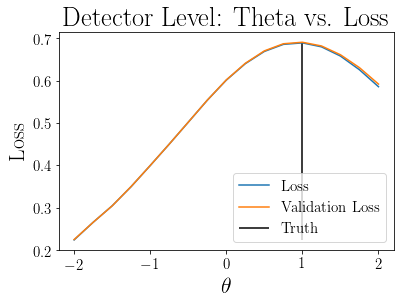

In [27]:
plt.plot(thetas, lvals_D, label='Loss')
plt.plot(thetas, vlvals_D, label='Validation Loss')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(lvals_D),
           ymax=np.max(lvals_D),
           label='Truth')
plt.title("Detector Level: Theta vs. Loss")
plt.legend()
# plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Detector-Level:-Theta-vs-Loss.png")
plt.show()

In [28]:
f = sp.interpolate.interp1d(thetas, lvals_D, fill_value="extrapolate")

print("Interpolated Maximum: ",
      sp.optimize.minimize(lambda x: -f(x), x0=0)['x'][0])

Interpolated Maximum:  0.9999999914183849


### Comparison Plot

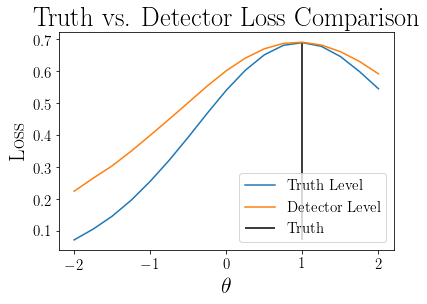

In [29]:
plt.plot(thetas, vlvals_T, label='Truth Level')
plt.plot(thetas, vlvals_D, label='Detector Level')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(vlvals_T + vlvals_D),
           ymax=np.max(vlvals_T + vlvals_D),
           label='Truth')
plt.title("Truth vs. Detector Loss Comparison")
plt.legend()
# plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Truth-vs-Detector-Loss-Comparison.png")
plt.show()

We've shown for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$

# More complex, uneven detector effects

To apply detector effects here, each event's primary truth observable $x_{T,i,0}$in the sample is smeared by shifting by $Z_{i}$ from $Z = \mathcal{N}((x_{T,i,1})^2,(x_{T,i,1})^2)$ ,where the square of the secondary truth observable $x_{T,i,1}$ represents the some shifting bias as well as smearing. Thus: $x_{D,i} = x_{T,i,0} + Z_{i}$

In [30]:
# Generate detector level by smearing truth

X0_val_D_new = np.array([(x[0] + np.random.normal(x[1]**2, x[1]**2))
                     for x in X0_val_T])  # Detector smearing
X1_val_D_new = np.array([(x[0] + np.random.normal(x[1]**2, x[1]**2))
                     for x in X1_val_T])  # Detector smearing

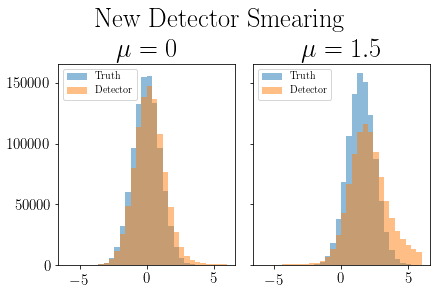

In [31]:
fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('New Detector Smearing')
axs[0].set_title('$\mu=0$')
axs[0].hist(X0_val_T[:,0], bins=bins, alpha=0.5, label='Truth')
axs[0].hist(X0_val_D_new, bins=bins, alpha=0.5, label='Detector')
axs[0].legend(prop=fontP, loc = 'upper left')
axs[1].set_title('$\mu={}$'.format(mu1))
axs[1].hist(X1_val_T[:,0], bins=bins, alpha=0.5, label='Truth')
axs[1].hist(X1_val_D_new, bins=bins, alpha=0.5, label='Detector')
axs[1].legend(prop=fontP, loc = 'upper left')
fig.show()

Note that the same validation weights will work here as reweighting only depends only on truth, which is determined by $(x_{T,i,0},x_{T,i,1})$ and not how the detector effects are applied, so long these effects depend solely on truth in some way.

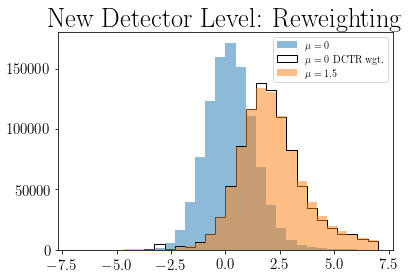

In [32]:
bins = np.linspace(-7, 7, 31)
plt.hist(X0_val_D_new, bins=bins, alpha=0.5, label=r'$\mu=0$')
plt.hist(X0_val_D_new,
         bins=bins,
         label=r'$\mu=0$ DCTR wgt.',
         weights=weights_val,
         histtype='step',
         color='k')
plt.hist(X1_val_D_new, bins=bins, alpha=0.5, label=r'$\mu={}$'.format(mu1))
plt.legend(prop=fontP)
plt.title("New Detector Level: Reweighting")
#plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-New-Detector-Level:Reweighting.png")
plt.show()

## Scanning with New Effects

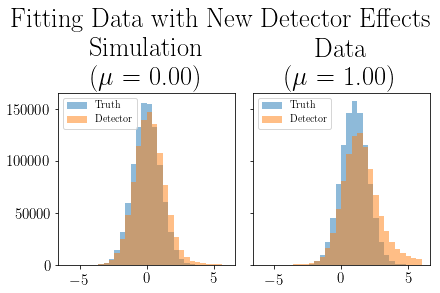

In [33]:
N = 10**6
theta0_param = 0  # this is the simulation ... N.B. this notation is reversed from above!
theta1_param = 1  # this is the data (the target)
sigma = 1.  # standard Gaussian width
# epsilon = sigma / 2  # Smearing width

theta0_T_0 = np.random.normal(theta0_param, sigma, N)  # Truth Level Data
theta0_T_1 = np.random.normal(0, nu(theta0_param), N)
theta0_T = np.stack((theta0_T_0, theta0_T_1), axis = -1)

theta0_D = np.array([(x[0] + np.random.normal(x[1]**2, x[1]**2))
                     for x in theta0_T])  # Detector smearing

theta0 = np.hstack([theta0_T, np.expand_dims(theta0_D, axis = -1)])

theta1_T = np.random.normal(theta1_param, sigma, N)
theta1_T_ep = np.random.normal(0, nu(theta1_param), N)
theta1_T = np.stack((theta1_T, theta1_T_ep), axis = -1)

theta1_D = np.array([(x[0] + np.random.normal(x[1]**2, x[1]**2))
                     for x in theta1_T])  # Detector smearing

theta1 = np.hstack([theta1_T, np.expand_dims(theta1_D, axis = -1)])

bins = np.linspace(-6, 6, 31)

fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('Fitting Data with New Detector Effects')

axs[0].set_title("Simulation\n($\mu$ = {:.2f})".format(theta0_param))
axs[0].hist(theta0_T[:,0], bins=bins, alpha=0.5, label='Truth')
axs[0].hist(theta0_D, bins=bins, alpha=0.5, label='Detector')
axs[0].legend(prop=fontP, loc = 'upper left')

axs[1].set_title("Data\n($\mu$ = {:.2f})".format(theta1_param))
axs[1].hist(theta1_T[:,0], bins=bins, alpha=0.5, label='Truth')
axs[1].hist(theta1_D, bins=bins, alpha=0.5, label='Detector')
axs[1].legend(prop=fontP, loc = 'upper left')

# fig.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Fitting-Data-with-New-Detector-Effects.png")
plt.show()

labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0, theta1])
yvals = np.concatenate([labels0, labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                    yvals,
                                                    test_size=0.5)
X_train_theta, y_train_theta = shuffle(xvals, yvals)

X_train_T, y_train_T = np.copy(X_train[:, :2]), y_train
X_test_T, y_test_T = np.copy(X_test[:, :2]), y_test
X_train_theta_T, y_train_theta_T = np.copy(X_train_theta[:, :2]), y_train_theta

#' Erasing' Truth level for data, we can't actually observe this
X_train[:, :2][y_train == 1], X_test[:, :2][y_test == 1] = 0., 0.
X_train_theta[:, :2][y_train_theta == 1] = 0.

# 'hiding' truth level for simulation in expected model output (used in reweighting)
X_train_D, y_train_D = X_train[:, 2], np.hstack([np.expand_dims(y_train, axis = -1), X_train[:, :2]])
X_test_D, y_test_D = X_test[:, 2], np.hstack([np.expand_dims(y_test, axis=-1), X_test[:, :2]])

X_train_theta_D, y_train_theta_D = X_train_theta[:, 1], np.hstack(
    [np.expand_dims(y_train_theta, axis = -1), X_train_theta[:, :2]])

Notice how detector smearing and right-shifting is more intense for "Data".

In [34]:
lvals_D_new = []
vlvals_D_new = []

for theta in thetas:
    print("Testing theta = ", theta)
    model_D.compile(optimizer='adam',
                  loss=my_loss_wrapper_D(theta,
                                         loss='categorical_crossentropy',
                                         batch_size=batch_size),
                  metrics=['accuracy'])

    history = model_D.fit(np.array(X_train_D),
                        y_train_D,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(np.array(X_test_D), y_test_D),
                        verbose=0,
                        callbacks=[earlystopping])

    min_lval = history.history['loss'][np.argmin(history.history['val_loss'])]
    min_vlval = np.min(history.history['val_loss'])

    lvals_D_new += [min_lval]
    vlvals_D_new += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass
print(lvals_D)

Testing theta =  -2.0
loss:  0.1482662498652935
val_loss:  0.14778789280354976


Testing theta =  -1.75
loss:  0.18439000046253204
val_loss:  0.18363221107423305


Testing theta =  -1.5
loss:  0.22190306615829467
val_loss:  0.22129595932364463


Testing theta =  -1.25
loss:  0.2679043566584587
val_loss:  0.2671674179136753


Testing theta =  -1.0
loss:  0.3206510362923145
val_loss:  0.31998802703619006


Testing theta =  -0.75
loss:  0.3788033929169178
val_loss:  0.37826479053497314


Testing theta =  -0.5
loss:  0.44216383263468745
val_loss:  0.4416236382126808


Testing theta =  -0.25
loss:  0.5083088766336441
val_loss:  0.507852195173502


Testing theta =  0.0
loss:  0.5710137573480606
val_loss:  0.570480607688427


Testing theta =  0.25
loss:  0.623732130408287
val_loss:  0.6229675885438919


Testing theta =  0.5
loss:  0.663171350300312
val_loss:  0.6619957021474838


Testing theta =  0.75
loss:  0.6864397933483124
val_loss:  0.6852429519891738


Testing theta =  1.0
loss:  0.6921

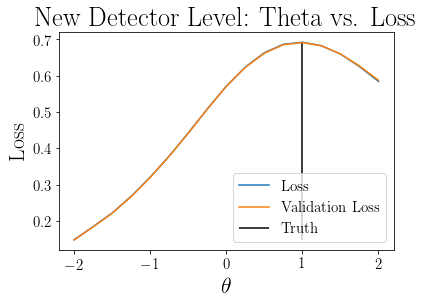

In [35]:
plt.plot(thetas, lvals_D_new, label='Loss')
plt.plot(thetas, vlvals_D_new, label='Validation Loss')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(lvals_D_new),
           ymax=np.max(lvals_D_new),
           label='Truth')
plt.title("New Detector Level: Theta vs. Loss")
plt.legend()
# plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-New-Detector-Level:-Theta-vs-Loss.png")
plt.show()

In [36]:
f = sp.interpolate.interp1d(thetas, lvals_D_new, fill_value="extrapolate")

print("Interpolated Maximum: ",
      sp.optimize.minimize(lambda x: -f(x), x0=0)['x'][0])

Interpolated Maximum:  0.9999999905759623


### Comparison Plot

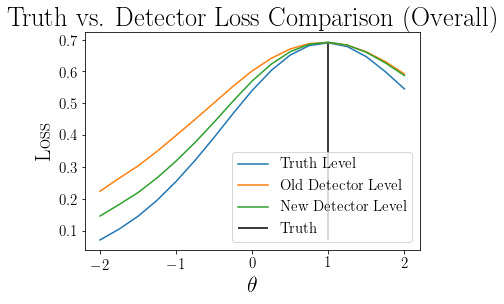

In [37]:
plt.plot(thetas, vlvals_T, label='Truth Level')
plt.plot(thetas, vlvals_D, label='Old Detector Level')
plt.plot(thetas, vlvals_D_new, label='New Detector Level')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(vlvals_T + vlvals_D + vlvals_D_new),
           ymax=np.max(vlvals_T + vlvals_D + vlvals_D_new),
           label='Truth')
plt.title("Truth vs. Detector Loss Comparison (Overall)")
plt.legend()
# plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Truth-vs-Detector-Loss-Comparison-Overall.png")
plt.show()